# 11-experiment-three-cogsci

## Integrity

In [32]:
# Analytical Tools
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# General Utilities
import itertools
import json
import pprint

# Custom Utilities
import utilities.plotting as plotting
import utilities.describe as describe

# Some settings
log = pprint.pprint
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.options.mode.chained_assignment = None

### Reading Data

In [33]:
GROUPS = 3
QUESTIONS = 4
JUDGMENTS = 4
SCORE_THRESHOLD = 240.9

FILE_NAMES = [
    'data/new-3.json',
]

master_responses = []
for name in FILE_NAMES:
    with open(name) as file:
        master_responses.extend(json.loads(line) for line in file if line)

In [34]:
def _get_group(score):
    if score is None:
        return 1
    if score < SCORE_THRESHOLD:
        return 0
    return 2

### Parsing Data

In [35]:
data = {
    'id': [],
    'consent': [],
    'attention': []
}

for g_num in range(GROUPS):
    for q_num in range(QUESTIONS):
        data['g{}_q{}_score'.format(g_num, q_num)] = []
        data['g{}_q{}_index'.format(g_num, q_num)] = []
        for j_num in range(JUDGMENTS):
            data['g{}_q{}_j{}'.format(g_num, q_num, j_num)] = []

In [36]:
ANSWER_KEYS = ('Q0', 'Q1', 'Q2', 'Q3')

for person in master_responses:
    # Grab data & ID
    person_data = person['data']  
    data['id'].append(person_data[0]['participantID'])
    
    # Fill in question labels
    question_scores = person_data[0]['questionScores']
    question_indices = person_data[0]['questionIndices']
    
    counters = [0, 0, 0]
    question_labels = []
    for score in question_scores:
        g_num = _get_group(score)
        question_labels.append('g{}_q{}'.format(g_num, counters[g_num]))
        counters[g_num] += 1
    
    for q_label, score in zip(question_labels, question_scores):
        data['{}_score'.format(q_label)].append(score)
    for q_label, index in zip(question_labels, question_indices):
        data['{}_index'.format(q_label)].append(index)
    
    # Get consent response
    consent_answer = json.loads(person_data[0]['responses'])
    consent_value = int(consent_answer['Q0'].startswith('I consent'))
    data['consent'].append(consent_value)

    # Fill in judgments
    judgment_indices = person_data[0]['judgmentIndices']
    
    for q_label, likert_index in zip(question_labels, range(2, 14)):
        answer = json.loads(person_data[likert_index]['responses'])
        for j_label, key in zip(judgment_indices, ANSWER_KEYS):
            rating = int(answer[key])
            data['{}_j{}'.format(q_label, j_label)].append(rating)

    # Attention check
    attention_answer = json.loads(person_data[8]['responses'])
    attention_value = int(attention_answer['Q4'] == '6')
    data['attention'].append(attention_value)

### Reading Responses into Data

In [37]:
data = pd.DataFrame(data)
sample_size = len(data)
data.head()

,id,consent,attention,g0_q0_score,g0_q0_index,g0_q0_j0,g0_q0_j1,g0_q0_j2,g0_q0_j3,g0_q1_score,...,g2_q2_j0,g2_q2_j1,g2_q2_j2,g2_q2_j3,g2_q3_score,g2_q3_index,g2_q3_j0,g2_q3_j1,g2_q3_j2,g2_q3_j3
0,hu18z57qr2ja4v6jh24c57fk0b5ftdqs,1,1,22,35,5,1,0,1,27,...,4,0,5,2,2395,36,4,0,3,3
1,xev0ec5nfz6bfwq1h4puuscnk0eg8ck8,1,1,40,18,3,0,2,1,28,...,3,4,3,3,2416,2,3,2,3,4
2,upfop1hxok2r4hynbr5yfwty3q5628wr,1,1,28,2,5,0,5,2,19,...,2,5,1,2,2404,40,1,2,4,3
3,goxzca1lx6vlbzmf9la861fhqlmtxlmn,1,1,32,27,4,2,4,3,41,...,5,0,4,3,2398,16,2,1,2,2
4,j06j83a97loyc5won1rk9hg46qrwnzbs,1,1,24,10,6,0,2,3,22,...,1,5,1,0,2388,8,4,0,4,1


In [38]:
print(len(data), data.size)
data = data[data.consent == 1]
print(len(data), data.size)
data = data[data.attention == 1]
print(len(data), data.size)

print('Inclusion: {:.4}% '.format(len(data) / sample_size * 100))

299 22425
299 22425
277 20775
Inclusion: 92.64% 


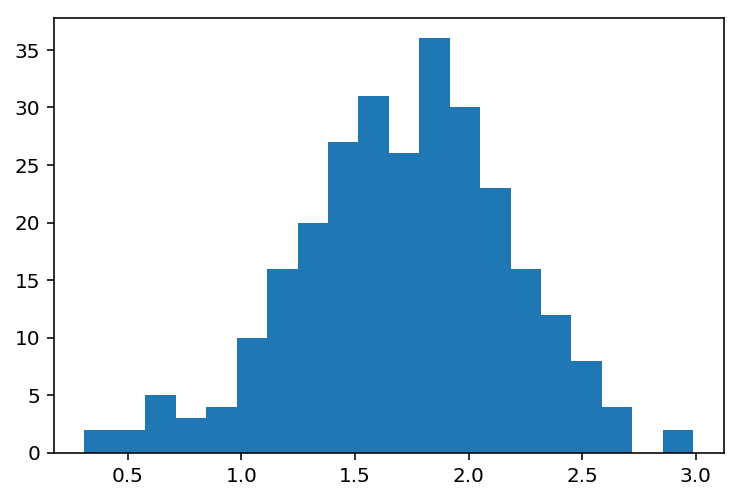

[[4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3
  3 3 3 3 3 3 3 3 3 3 3 3]]


In [39]:
judgments = []
for g_num in range(GROUPS):
    for q_num in range(QUESTIONS):
        for j_num in range(JUDGMENTS):
            judgments.append('g{}_q{}_j{}'.format(g_num, q_num, j_num))
scores = data[judgments]
data['j_mean'] = scores.mean(axis=1)
data['j_std'] =scores.std(axis=1)

plt.hist(data['j_std'], bins=20)
plt.show()

index = np.argmin(data['j_std'])
print(scores.loc[[index]].values)

In [40]:
print(len(data), data.size)
data = data[data.j_std > 0.75]
index = np.argmin(data['j_std'])
print(scores.loc[[index]].values)
print('Inclusion: {:.4}% '.format(len(data) / sample_size * 100))

277 21329
[[3 4 6 4 5 4 5 4 5 4 5 4 4 5 4 4 4 3 3 4 2 3 4 3 3 4 5 5 5 5 4 4 3 5 4 4
  4 3 3 4 3 4 4 5 4 5 4 4]]
Inclusion: 89.63% 


### Saving Data

In [41]:
data.to_pickle('data/responses.pkl')